In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import gc

import numpy as np

sys.path.append("..")
from dm21cm.dm_params import DMParams

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file("../matplotlibrc")

In [2]:
"""Main evolution function."""

import os
import sys
import logging

import numpy as np
from scipy import interpolate
from astropy.cosmology import Planck18
import astropy.units as u
import jax.numpy as jnp

import py21cmfast as p21c
from py21cmfast import cache_tools

sys.path.append(os.environ['DH_DIR']) # use branch test_dm21cm
from darkhistory.spec.spectrum import Spectrum

sys.path.append("..")
import dm21cm.physics as phys
from dm21cm.dh_wrappers import DarkHistoryWrapper, TransferFunctionWrapper
from dm21cm.utils import load_h5_dict
from dm21cm.data_cacher import Cacher
from dm21cm.profiler import Profiler

logging.getLogger().setLevel(logging.INFO)
logging.getLogger('21cmFAST').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [3]:
#===== utilities for evolve =====

def get_z_edges(z_max, z_min, zplusone_step_factor):
    z_s = [z_min]
    while z_s[-1] < z_max:
        z_s.append((z_s[-1] + 1.0) * zplusone_step_factor - 1.0)
    
    return np.clip(z_s[::-1], None, z_max)


def split_xray(phot_N, phot_eng):
    """Split a photon spectrum (N in bin) into bath and xray band."""

    ex_lo, ex_hi = 1e2, 1e4 # [eV]
    ix_lo = np.searchsorted(phot_eng, ex_lo) # i of first bin greater than ex_lo, excluded
    ix_hi = np.searchsorted(phot_eng, ex_hi) # i of first bin greater than ex_hi, included

    bath_N = np.array(phot_N).copy()
    xray_N = np.array(phot_N).copy()
    bath_N[ix_lo:ix_hi] *= 0
    xray_N[:ix_lo] *= 0
    xray_N[ix_hi:] *= 0
    
    return bath_N, xray_N


def gen_injection_boxes(z_next, p21c_initial_conditions):
    
    input_heating = p21c.input_heating(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    
    return input_heating, input_ionization, input_jalpha

global_astro_params = p21c.AstroParams(
    L_X = 0. # L_X = 10**0.
)

def p21c_step(perturbed_field, spin_temp, ionized_box,
             input_heating=None, input_ionization=None, input_jalpha=None):
    
    # Calculate the spin temperature, possibly using our inputs
    spin_temp = p21c.spin_temperature(
        perturbed_field = perturbed_field,
        previous_spin_temp = spin_temp,
        input_heating_box = input_heating,
        input_ionization_box = input_ionization,
        input_jalpha_box = input_jalpha,
        astro_params=global_astro_params,
    )
    
    # Calculate the ionized box
    ionized_box = p21c.ionize_box(
        perturbed_field = perturbed_field,
        previous_ionize_box = ionized_box,
        spin_temp = spin_temp,
        astro_params=global_astro_params,
    )
    
    # Calculate the brightness temperature
    brightness_temp = p21c.brightness_temperature(
        ionized_box = ionized_box,
        perturbed_field = perturbed_field,
        spin_temp = spin_temp
    )
    
    return spin_temp, ionized_box, brightness_temp

In [49]:
run_name = 'test'
z_start = 45.
z_end = 5.
zplusone_step_factor = 1.01
dm_params = DMParams(
    mode = 'swave',
    primary = 'phot_delta',
    m_DM = 1e10,
    sigmav = 1e-23,
    struct_boost_model = 'erfc 1e-3',
)
enable_elec = False
tf_version = '230629xc'

p21c_initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = 128,
        BOX_LEN = 128 * 2, # [conformal Mpc]
        N_THREADS = 32,
    ),
    cosmo_params = p21c.CosmoParams(
        OMm = Planck18.Om0,
        OMb = Planck18.Ob0,
        POWER_INDEX = Planck18.meta['n'],
        SIGMA_8 = Planck18.meta['sigma8'],
        hlittle = Planck18.h,
    ),
    random_seed = 3458,
    write = True,
)

rerun_DH = False
clear_cache = True
use_tqdm = False
debug_flags = []

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


In [61]:
logging.info(f'Using 21cmFAST version {p21c.__version__}')

#===== cache and memory =====
p21c.config['direc'] = f"{os.environ['P21C_CACHE_DIR']}/{run_name}"
logging.info(f"Cache dir: {p21c.config['direc']}")
os.makedirs(p21c.config['direc'], exist_ok=True)
if clear_cache:
    cache_tools.clear_cache()
gc.collect()

#===== initialize =====
#--- physics parameters ---
p21c.global_params.Z_HEAT_MAX = z_start
p21c.global_params.ZPRIME_STEP_FACTOR = zplusone_step_factor
p21c.global_params.CLUMPING_FACTOR = 1.
EPSILON = 1e-6

abscs = load_h5_dict(f'../data/abscissas/abscs_{tf_version}.h5')
if not np.isclose(np.log(zplusone_step_factor), abscs['dlnz']):
    raise ValueError('zplusone_step_factor and tf_version mismatch')
dm_params.set_inj_specs(abscs)

box_dim = p21c_initial_conditions.user_params.HII_DIM
box_len = p21c_initial_conditions.user_params.BOX_LEN
cosmo = Planck18

#--- DarkHistory and transfer functions ---
dh_wrapper = DarkHistoryWrapper(
    dm_params,
    prefix = p21c.config[f'direc'],
)

#--- redshift stepping ---
z_edges = get_z_edges(z_start, z_end, p21c.global_params.ZPRIME_STEP_FACTOR)

#===== initial step =====
dh_wrapper.evolve(end_rs=(1+z_start)*0.9, rerun=rerun_DH)
#mean_T_k, mean_x_e = dh_wrapper.match(spin_temp, ionized_box)
mean_T_k, mean_x_e = 1e-5, 1e-5
p21c.global_params.TK_at_Z_HEAT_MAX = mean_T_k
p21c.global_params.XION_at_Z_HEAT_MAX = mean_x_e
phot_bath_spec = dh_wrapper.get_phot_bath(rs=1+z_edges[0])

perturbed_field = p21c.perturb_field(redshift=z_edges[0], init_boxes=p21c_initial_conditions)
spin_temp, ionized_box, brightness_temp = p21c_step(perturbed_field=perturbed_field, spin_temp=None, ionized_box=None)

INFO:root:Using 21cmFAST version 0.1.dev1580+g2fe9754
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/test
INFO:root:DarkHistoryWrapper: Found existing DarkHistory initial conditions.


In [73]:
p21c.FlagOptions()

FlagOptions(FIX_VCB_AVG:False, INHOMO_RECO:False, M_MIN_in_Mass:True, PHOTON_CONS:False, SUBCELL_RSD:False, USE_HALO_FIELD:False, USE_MASS_DEPENDENT_ZETA:True, USE_MINI_HALOS:False, USE_TS_FLUCT:False)

In [68]:
spin_temp._global_params.TK_at_Z_HEAT_MAX

1e-05

In [69]:
spin_temp._global_params.XION_at_Z_HEAT_MAX

1e-05

Text(0.5, 1.0, 'xe is set to 1e-5')

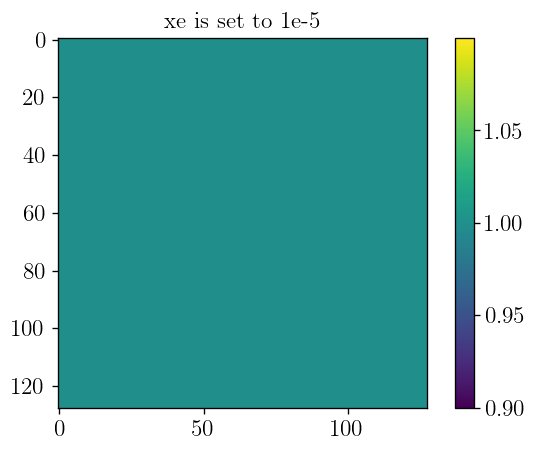

In [62]:
plt.imshow(spin_temp.x_e_box[0])
plt.colorbar()
plt.title('xe is set to 1e-5')

In [63]:
np.mean(spin_temp.x_e_box)

0.99999994

In [64]:
spin_temp.redshift

45.0

In [65]:
np.mean(spin_temp.Tk_box)

125.48818

Text(0.5, 1.0, 'Tk is set to 1e-5')

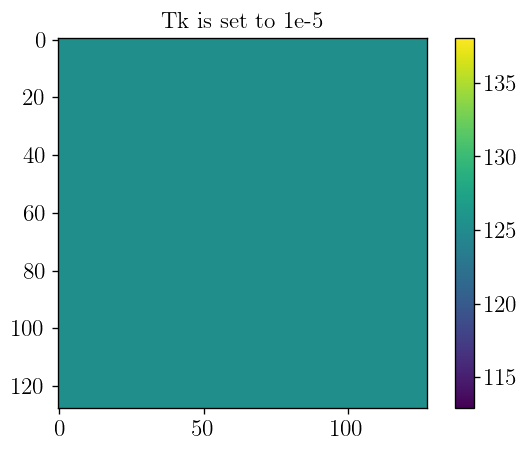

In [66]:
plt.imshow(spin_temp.Tk_box[0])
plt.colorbar()
plt.title('Tk is set to 1e-5')

In [5]:
p21c.global_params

GlobalParams(ALPHA_UVB=5.0;CLUMPING_FACTOR=2.0;CRIT_DENS_TRANSITION=1.5;DELTA_CRIT_MODE=1;DELTA_R_FACTOR=1.100000023841858;DELTA_R_HII_FACTOR=1.100000023841858;EVOLVE_DENSITY_LINEARLY=0;FILTER=0;FIND_BUBBLE_ALGORITHM=2;HALO_FILTER=0;HEAT_FILTER=0;HII_FILTER=1;HII_ROUND_ERR=9.999999747378752e-06;INITIAL_REDSHIFT=300.0;MAX_DVDR=0.20000000298023224;MIN_DENSITY_LOW_LIMIT=9.000000034120603e-08;M_MAX_INTEGRAL=1.0000000272564224e+16;M_MIN_INTEGRAL=100000.0;M_WDM=2.0;NBINS_LF=100;NUM_FILTER_STEPS_FOR_Ts=40;NU_X_BAND_MAX=2000.0;NU_X_MAX=10000.0;N_POISSON=5;OMk=0.0;OMn=0.0;OMr=8.600000001024455e-05;OMtot=1.0;OPTIMIZE=0;OPTIMIZE_MIN_MASS=99999997952.0;P_CUTOFF=0;PhotonConsAsymptoteTo=0.009999999776482582;PhotonConsEnd=0.30000001192092896;PhotonConsEndCalibz=3.5;PhotonConsStart=0.9950000047683716;Pop=2;Pop2_ion=5000.0;Pop3_ion=44021.0;R_BUBBLE_MIN=0.6203504800796509;R_OVERLAP_FACTOR=1.0;R_XLy_MAX=500.0;R_smooth_density=0.20000000298023224;RecombPhotonCons=0;SHETH_b=0.15000000596046448;SHETH_c=0.05

In [35]:
np.mean(spin_temp.Tk_box), np.mean(spin_temp.x_e_box)

(242.32991, 0.0057613607)

In [36]:
z_edges[0], z_edges[1]

(45.0, 44.67846508307498)

In [37]:
perturbed_field = p21c.perturb_field(redshift=z_edges[1], init_boxes=p21c_initial_conditions)

In [38]:
spin_temp = p21c.spin_temperature(
    perturbed_field = perturbed_field,
    previous_spin_temp = spin_temp,
    input_heating_box = None,
    input_ionization_box = None,
    input_jalpha_box = None,
    write=True,
)

In [39]:
np.mean(spin_temp.Tk_box)

40.20591

In [31]:
os.listdir(os.environ['P21C_CACHE_DIR']+'/test')

['IonizedBox_669a86d5ccc561535be3cc44fa387174_r54321.h5',
 'BrightnessTemp_aa5af2d9482c35f94212b81caa89b093_r54321.h5',
 'PerturbedField_61c17a37cfa4fbf33c31f1b8c831a186_r54321.h5',
 'dh_init_soln.p',
 'TsBox_1e5806275944908f8dd13625d8befc1a_r54321.h5',
 'PerturbedField_593ee2d337d9a446d967e4d1d760967b_r54321.h5',
 'xraycheck_brightness.h5',
 'TsBox_df092d5cf742677ce97b15765fc607d1_r54321.h5',
 'InitialConditions_21beb02d574389c977e5ff74ec0d8b7c_r54321.h5']

In [ ]:
spin_temp, ionized_box, brightness_temp = p21c_step(perturbed_field=perturbed_field, spin_temp=None, ionized_box=None)

In [ ]:
def p21c_step(perturbed_field, spin_temp, ionized_box,
             input_heating=None, input_ionization=None, input_jalpha=None):
    
    # Calculate the spin temperature, possibly using our inputs
    spin_temp = p21c.spin_temperature(
        perturbed_field = perturbed_field,
        previous_spin_temp = spin_temp,
        input_heating_box = input_heating,
        input_ionization_box = input_ionization,
        input_jalpha_box = input_jalpha,
        astro_params=global_astro_params,
    )
    
    # Calculate the ionized box
    ionized_box = p21c.ionize_box(
        perturbed_field = perturbed_field,
        previous_ionize_box = ionized_box,
        spin_temp = spin_temp,
        astro_params=global_astro_params,
    )
    
    # Calculate the brightness temperature
    brightness_temp = p21c.brightness_temperature(
        ionized_box = ionized_box,
        perturbed_field = perturbed_field,
        spin_temp = spin_temp
    )
    
    return spin_temp, ionized_box, brightness_temp